<a href="https://colab.research.google.com/github/maschmidt87/Project-Repository/blob/master/Veteran_OSA_claim_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Veteran OSA (Obstructive Sleep Apnea) claim analysis project##
In this project we will be examing a .csv file containing raw data related to veteran disability claims filed by a consulting business on behalf of US veterans.  We are interested in identifying factors associated improved outcomes associated with claim approval and value on behalf of the veteran.  Recommendations for the business assisting the clients with filing claims are to made, with answers to questions listed below.

These clients have have filed an OSA (Obstructive Sleep Apnea) claim, and in some cases a Back and Spine Claim or a Lower Extremities Claim.  These claims have been adjudiated, with revenue values indicated.  
Veterans have also done a screening where they have provided some individual data

Claim variables:
packet_id - a unique identifier of the claim packet filed
packet_date - the date on which the packet was filed
back_spine_claim - 0 indicates no back spine claim was filed / 1 indicates a back spine claim was filed
lower_extremities_claim- 0 indicates no lower extremities claim was filed / 1 indicates a lower extremities claim was filed
osa_claim - 1 indicates an OSA claim was filed (all values = 1)

Veteran variables: (a null value indicates the Vet did not provide a response)
has_go_to_sick_call - 1 indicates the vet went to sick call for an injury during his service / 0 that he did not
branch_of_service - a text string indicating branch(es) of service
current_height_in_inches - the Vet's response for his current height (in inches)
current_weightpounds - the Vet's response for his current weight (in pounds)
gender - the Vet's response indicating his gender
is_sleep_study - a value of 1 indicates the Vet participated in a sleep study / 0 that he did not

BMI is defined as:
bmi = (weight * 703) / (height ^ 2)

The CDC definbes BMI categories as:
Underweight = <18.5
Normal weight = 18.5–24.9
Overweight = 25–29.9
Obesity = BMI of 30 or greater 

Revenue:
adjudicated_claim_value - the amount (in dollars) that the Vet's claim is worth (0 indicates that the Vet's claim(s) were denied).

#Questions:
- What is the revenue that the business can expect to receive from filing an OSA claim?
- What is the probability that the business will "win" an OSA claim (adjudicated_claim_value > 0)?

- How does this value change with different Vet demographics?  with different additional claims filed?  trends through time?
- What advice would you give to the business in how it handles its OSA claims?

In [1]:
#first let's import our libraries 
from google.colab import drive

drive.mount("/content/drive")

# Import required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
 

# This library contains a large number of probability distributions as well as a growing library of statistical functions
import scipy.stats as stats

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)

Mounted at /content/drive


In [2]:
#Import our uploaded CSV file from the Google drive and view head
path = '/content/drive/MyDrive/Colab_data/Data Project.csv'
df = pd.read_csv(path)
df.head()

,packet_id,packet_date,back_spine_claim,lower_extremities_claim,osa_claim,has_go_to_sick_call,branch_of_service,current_height_in_inches,current_weightpounds,gender,is_sleep_study,adjudicated_claim_value
0,65ae12ba408312bd298f7548c15f4ba7,7-Oct-20,0,0,1,0.0,NaN,73.0,260.0,Male,1.0,2664.80
1,ad259bb13777881b9cfde625a36826be,16-Jun-21,0,0,1,0.0,NaN,70.0,236.0,Male,1.0,0.00
2,6d4d96ae95822afc1b1dee303995f5a9,9-Feb-22,0,0,1,0.0,NaN,70.0,236.0,Male,1.0,0.00
3,18c82e6eac352c538389789c5b5bfdf5,9-Mar-21,0,0,1,0.0,NaN,69.0,288.0,Male,1.0,2602.35
4,46803c4330fee4bec68f8334acc106a7,17-May-22,0,0,1,0.0,NaN,72.0,191.0,Male,1.0,0.00


In [3]:
#View info for dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3745 entries, 0 to 3744
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   packet_id                 3745 non-null   object 
 1   packet_date               3745 non-null   object 
 2   back_spine_claim          3745 non-null   int64  
 3   lower_extremities_claim   3745 non-null   int64  
 4   osa_claim                 3745 non-null   int64  
 5   has_go_to_sick_call       3438 non-null   float64
 6   branch_of_service         2180 non-null   object 
 7   current_height_in_inches  3438 non-null   float64
 8   current_weightpounds      3438 non-null   float64
 9   gender                    1258 non-null   object 
 10  is_sleep_study            3438 non-null   float64
 11  adjudicated_claim_value   3745 non-null   float64
dtypes: float64(5), int64(3), object(4)
memory usage: 351.2+ KB


In [4]:
#View null values sum for each variable
#Let's see what values have NaN values that we will need to eliminate:
df.isnull().sum()

packet_id                      0
packet_date                    0
back_spine_claim               0
lower_extremities_claim        0
osa_claim                      0
has_go_to_sick_call          307
branch_of_service           1565
current_height_in_inches     307
current_weightpounds         307
gender                      2487
is_sleep_study               307
adjudicated_claim_value        0
dtype: int64

After importing the CSV, the dataset contains 3745 entries in 12 columns total, with at least 307 missing values in 6 columns, such that we can assume that 3745 claims were filed.
 Missing values were variables unable to be collected from the veterans. Branch of service (n=1565) and gender (n=2487) were the primary variables with missing values.


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
back_spine_claim,3745.0,0.008278,0.090617,0.0,0.0,0.0,0.0,1.0
lower_extremities_claim,3745.0,0.018425,0.134499,0.0,0.0,0.0,0.0,1.0
osa_claim,3745.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
has_go_to_sick_call,3438.0,0.083479,0.276645,0.0,0.0,0.0,0.0,1.0
current_height_in_inches,3438.0,91.004363,1110.386410,5.0,67.0,70.0,72.0,65133.0
current_weightpounds,3438.0,231.606748,73.219473,20.0,200.0,225.0,255.0,2450.0
is_sleep_study,3438.0,0.914194,0.280118,0.0,1.0,1.0,1.0,1.0
adjudicated_claim_value,3745.0,1757.734955,2530.938469,0.0,0.0,0.0,2839.8,17589.2




*   Less than 1% of veterans filed a back spine claim, while 2% filed a lower extremity claims
*   Less than 10% of veterans went to sick call during service
*   Height and weight have extreme min/max values, indicating errors in data input
*   Most (91%) of veterans were enrolled in the sleep study


On average, a claim will generate a benefit of $1757.75 per OSA claim submitted by the business, though at least 50% of claims will yield no revenue at all. We will explore this further.

In [9]:
#Calculate percentage of total claims that were won (ie. win-rate)
win_rate = 1-df['adjudicated_claim_value'].value_counts()[0]/df['adjudicated_claim_value'].count()
win_rate

0.485981308411215


We can thus assert that 49% of cases are approved, so we can assume that the probability of winning a claim is just under 50%.


Before we conduct further data analysis to understand relevant factors for claim acceptance, let’s first clean up the dataset and convert all variables into a numerical format:
Fill NaN values with ‘NA’ placeholder for branch_of_service, gender columns
Create column to identify ‘win’ cases (ie. claim value > 0) in binary format
Create ‘Year’ column based on packet_date
Drop remaining NaN values (307 rows)
Create ‘BMI’ column using weight, height values
Drop rows with extreme BMI values (less than 10, greater than 80)
Classify BMI values into underweight, normal, overweight, and obesity variables
Create dummy variables for BMI class, military branch, gender, and year
Drop packet_id, packet_date, osa_claim


In [10]:
df_new = df.copy()
df_new = df_new.drop(['packet_id','osa_claim'], axis =1)
df_new['branch_of_service'] = df_new['branch_of_service'].fillna("NA")
df_new['gender'] = df_new['gender'].fillna("NA")
df_new['win'] = round(df_new['adjudicated_claim_value'])
df_new['win']=df_new['win'].astype(int)

df_new['win_value'] = np.where(df_new['win']==0, 0, 1)
df_new = df_new.drop(['win'], axis =1)

df_new['Year'] = df_new['packet_date'].str[-2:]
df_new = df_new.drop(['packet_date'], axis =1)

df_new = df_new.dropna(subset=['has_go_to_sick_call'])

df_new['current_weightpounds'] = df_new['current_weightpounds'].astype(int)
df_new['current_height_in_inches'] = df_new['current_height_in_inches'].astype(int)
df_new['BMI'] = df_new['current_weightpounds']*703/df_new['current_height_in_inches']/df_new['current_height_in_inches']

df_new['BMI_class'] = 'BMI_placeholder'
df_new.loc[(df_new['BMI'] > 0) & (df_new['BMI'] < 18.5), 'BMI_class'] = 'Underweight'
df_new.loc[(df_new['BMI'] >= 18.5) & (df_new['BMI'] < 25), 'BMI_class'] = 'Normal_weight'
df_new.loc[(df_new['BMI'] >= 25) & (df_new['BMI'] < 30), 'BMI_class'] = 'Overweight'
df_new.loc[(df_new['BMI'] >= 30), 'BMI_class'] = 'Obesity'

df_new= df_new[df_new['BMI'] < 80]
df_new= df_new[df_new['BMI'] > 10]

df_new = pd.get_dummies(df_new)

df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3334 entries, 0 to 3744
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   back_spine_claim                               3334 non-null   int64  
 1   lower_extremities_claim                        3334 non-null   int64  
 2   has_go_to_sick_call                            3334 non-null   float64
 3   current_height_in_inches                       3334 non-null   int64  
 4   current_weightpounds                           3334 non-null   int64  
 5   is_sleep_study                                 3334 non-null   float64
 6   adjudicated_claim_value                        3334 non-null   float64
 7   win_value                                      3334 non-null   int64  
 8   BMI                                            3334 non-null   float64
 9   branch_of_service_Air Force                    3334 

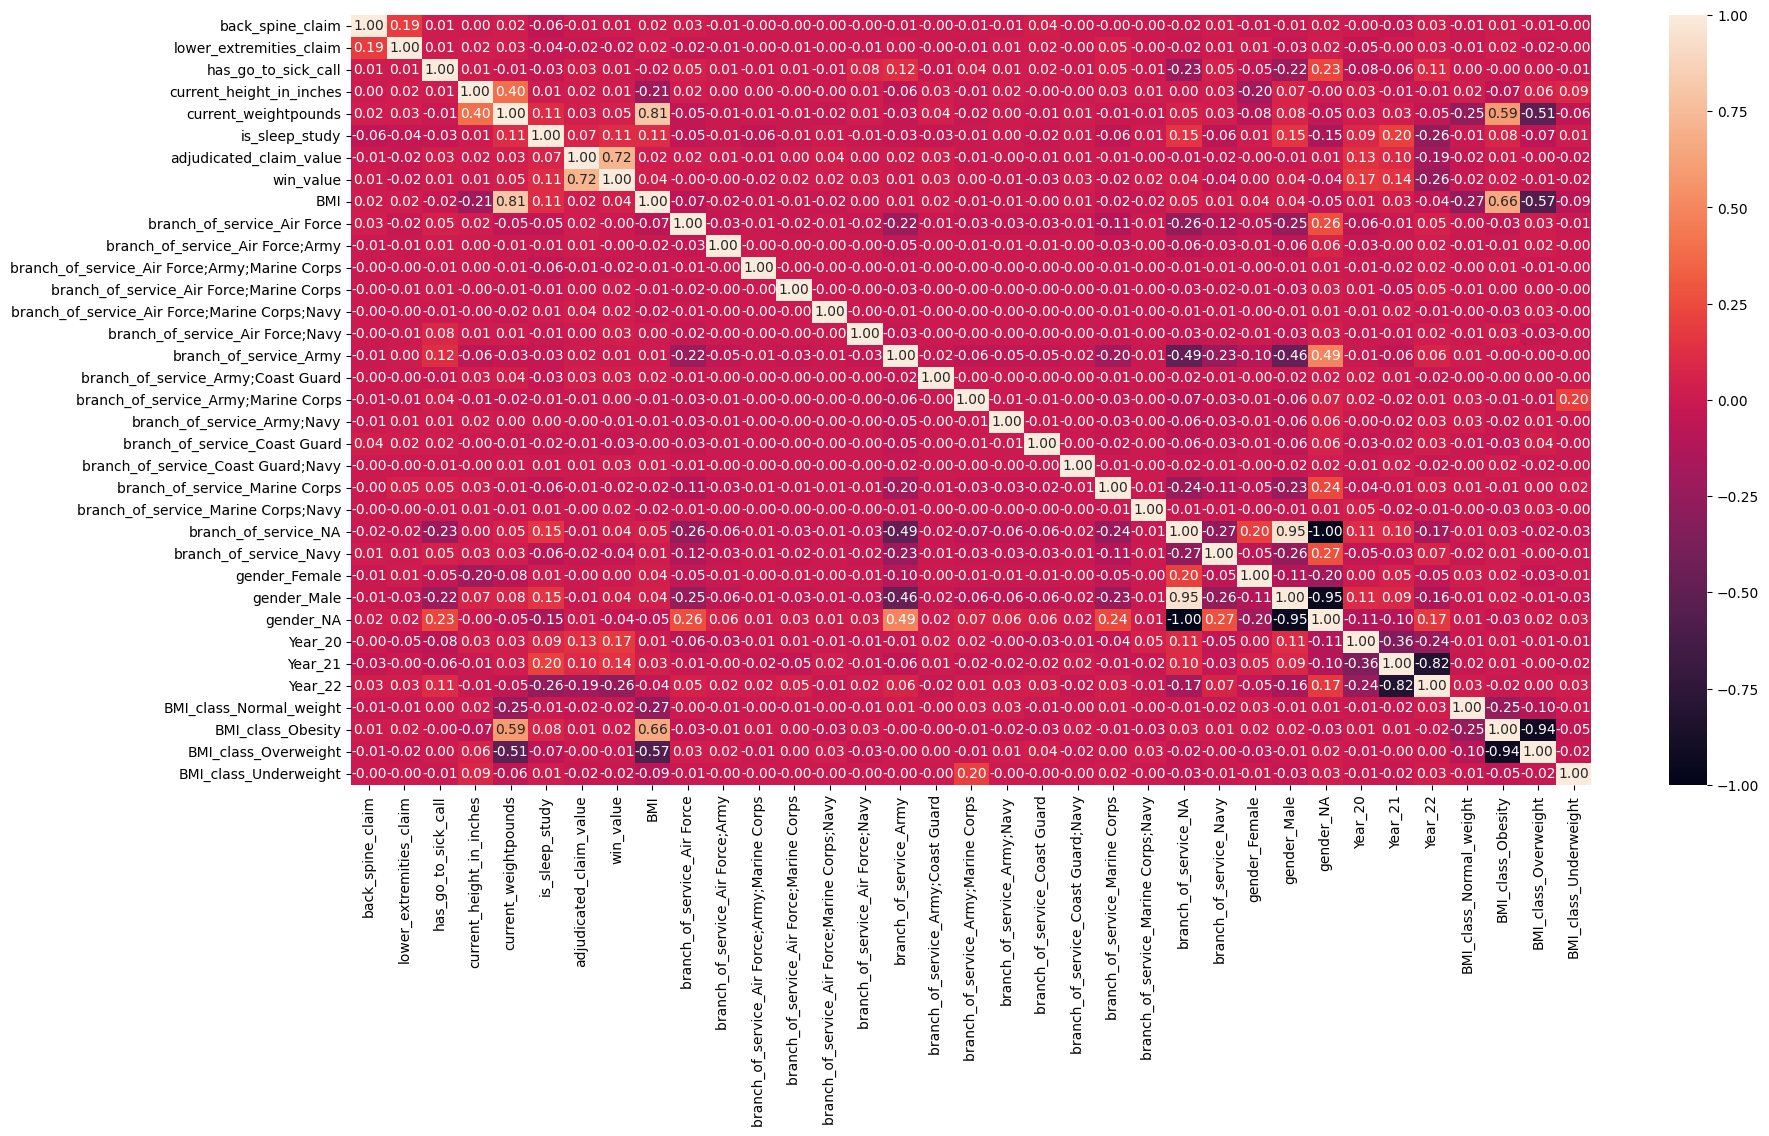

In [11]:
#Create a heatmap to view R-values in relation to the win-rate
plt.figure(figsize=(20,10))
sns.heatmap(df_new.corr(),annot=True,fmt=".2f")
plt.show()

The only notable R-value between win_value and another variable is 'is_sleep_study' with R=.11. We will need to look at win-rates based on each individual variable.

In [41]:
#simplify branch dummies by adding up all categories that have more than one branch included
df_new['branch_of_service_multiple'] = df_new['branch_of_service_Air Force;Army']+df_new['branch_of_service_Air Force;Army;Marine Corps']+df_new['branch_of_service_Air Force;Marine Corps']+df_new['branch_of_service_Air Force;Marine Corps;Navy']+df_new['branch_of_service_Air Force;Navy']+df_new['branch_of_service_Army;Coast Guard']+df_new['branch_of_service_Army;Marine Corps']+df_new['branch_of_service_Army;Navy']+df_new['branch_of_service_Coast Guard;Navy']+df_new['branch_of_service_Marine Corps;Navy']
df_new = df_new.drop(['branch_of_service_Air Force;Army','branch_of_service_Air Force;Army;Marine Corps','branch_of_service_Air Force;Marine Corps','branch_of_service_Air Force;Marine Corps;Navy','branch_of_service_Air Force;Navy','branch_of_service_Army;Coast Guard','branch_of_service_Army;Marine Corps','branch_of_service_Army;Navy','branch_of_service_Coast Guard;Navy','branch_of_service_Marine Corps;Navy'], axis =1)

In [42]:
#View dataset description with dummy variables created
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
back_spine_claim,3334.0,0.007499,0.086282,0.000000,0.000000,0.000000,0.000000,1.000000
lower_extremities_claim,3334.0,0.018896,0.136179,0.000000,0.000000,0.000000,0.000000,1.000000
has_go_to_sick_call,3334.0,0.084583,0.278302,0.000000,0.000000,0.000000,0.000000,1.000000
current_height_in_inches,3334.0,69.337732,3.754374,52.000000,67.000000,70.000000,72.000000,104.000000
current_weightpounds,3334.0,229.867427,44.404461,120.000000,200.000000,225.000000,254.000000,521.000000
is_sleep_study,3334.0,0.914517,0.279641,0.000000,1.000000,1.000000,1.000000,1.000000
adjudicated_claim_value,3334.0,1687.902399,2447.017077,0.000000,0.000000,0.000000,2779.800000,17589.200000
win_value,3334.0,0.479604,0.499659,0.000000,0.000000,0.000000,1.000000,1.000000
BMI,3334.0,33.643279,6.181567,16.314072,29.342344,32.687067,36.914514,76.929847
branch_of_service_Air Force,3334.0,0.106479,0.308496,0.000000,0.000000,0.000000,0.000000,1.000000


In [13]:
#Let's look at year on its own
df_new[['Year_20','Year_21','Year_22']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
Year_20,3334.0,0.095681,0.294197,0.0,0.0,0.0,0.0,1.0
Year_21,3334.0,0.547990,0.497766,0.0,0.0,1.0,1.0,1.0
Year_22,3334.0,0.356329,0.478986,0.0,0.0,0.0,1.0,1.0



Most claims (90%) were filed in either 2021 or 2022.

```



In [14]:
#gender on its own
df_new[['gender_Female','gender_Male','gender_NA']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
gender_Female,3334.0,0.023095,0.150229,0.0,0.0,0.0,0.0,1.0
gender_Male,3334.0,0.342831,0.474727,0.0,0.0,0.0,1.0,1.0
gender_NA,3334.0,0.634073,0.481761,0.0,0.0,1.0,1.0,1.0


More than 60% of claimants did not include their gender.  Only 2% of veterans were for women.

In [ ]:
#Let's look at additional claims and sleep study

In [15]:
df_new[['back_spine_claim','lower_extremities_claim','has_go_to_sick_call','is_sleep_study']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
back_spine_claim,3334.0,0.007499,0.086282,0.0,0.0,0.0,0.0,1.0
lower_extremities_claim,3334.0,0.018896,0.136179,0.0,0.0,0.0,0.0,1.0
has_go_to_sick_call,3334.0,0.084583,0.278302,0.0,0.0,0.0,0.0,1.0
is_sleep_study,3334.0,0.914517,0.279641,0.0,1.0,1.0,1.0,1.0


Less than 1% of veterans filed a back spine claim as well, while only 2% filed a lower extremity. 

In [16]:
#Let's look at BMI demographics
df_new[['BMI_class_Normal_weight','BMI_class_Obesity','BMI_class_Underweight','BMI_class_Overweight']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
BMI_class_Normal_weight,3334.0,0.025795,0.158547,0.0,0.0,0.0,0.0,1.0
BMI_class_Obesity,3334.0,0.696461,0.459855,0.0,0.0,1.0,1.0,1.0
BMI_class_Underweight,3334.0,0.001200,0.034622,0.0,0.0,0.0,0.0,1.0
BMI_class_Overweight,3334.0,0.276545,0.447356,0.0,0.0,0.0,1.0,1.0


70% of claimants were classified as obese, with an additional 28% classified as overweight. So, nearly all claimants are above a healthy BMI.

In [44]:
#Let's look at the branches served:
branch = df_new[['branch_of_service_multiple','branch_of_service_NA','branch_of_service_Army','branch_of_service_Navy','branch_of_service_Air Force','branch_of_service_Marine Corps','branch_of_service_Coast Guard']].describe(include = 'all').T
df_branch = pd.DataFrame(branch)
df_branch = df_branch.sort_values(by = ['mean'], ascending = False).head(50)
df_branch.head(20)

,count,mean,std,min,25%,50%,75%,max
branch_of_service_NA,3334.0,0.365927,0.481761,0.0,0.0,0.0,1.0,1.0
branch_of_service_Army,3334.0,0.290642,0.454127,0.0,0.0,0.0,1.0,1.0
branch_of_service_Navy,3334.0,0.112777,0.316368,0.0,0.0,0.0,0.0,1.0
branch_of_service_Air Force,3334.0,0.106479,0.308496,0.0,0.0,0.0,0.0,1.0
branch_of_service_Marine Corps,3334.0,0.089682,0.285769,0.0,0.0,0.0,0.0,1.0
branch_of_service_multiple,3334.0,0.028494,0.166405,0.0,0.0,0.0,0.0,1.0
branch_of_service_Coast Guard,3334.0,0.005999,0.077231,0.0,0.0,0.0,0.0,1.0


More than ⅓ of claimants (36%) did not list the branch in which they served. The Army was the most popular branch (29%), followed by Navy (11%), Air Force (11%), Marine Corps (9%), and Coast Guard (1%). An additional % of veterans served in more than one military branch.


Let's now look at each variable individually and see how it affects the claim win-rate.

In [18]:
#let's look at backspine claims filed
df_back= df_new[df_new['back_spine_claim'] == 1]
df_back[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,25.0,1470.527,2041.073859,0.0,0.0,591.65,1878.772,6761.6
win_value,25.0,0.520,0.509902,0.0,0.0,1.00,1.000,1.0


In [19]:
#let's look at backspine claims not filed
df_back_0= df_new[df_new['back_spine_claim'] == 0]
df_back_0[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,3309.0,1689.544703,2450.012471,0.0,0.0,0.0,2797.35,17589.2
win_value,3309.0,0.479299,0.499647,0.0,0.0,0.0,1.00,1.0


In [20]:
#lower_extremities_claim filed
df_lower= df_new[df_new['lower_extremities_claim'] == 1]
df_lower[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,63.0,1366.599825,2189.410660,0.0,0.0,0.0,1557.697,8249.152
win_value,63.0,0.396825,0.493169,0.0,0.0,0.0,1.000,1.000


In [21]:
#lower_extremities_claim not filed
df_lower= df_new[df_new['lower_extremities_claim'] == 0]
df_lower[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,3271.0,1694.090740,2451.599907,0.0,0.0,0.0,2788.575,17589.2
win_value,3271.0,0.481198,0.499723,0.0,0.0,0.0,1.000,1.0


In [22]:
#has_go_to_sick_call
df_sick= df_new[df_new['has_go_to_sick_call'] == 1]
df_sick[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,282.0,1940.899191,2697.824217,0.0,0.0,0.0,2885.131,12553.25
win_value,282.0,0.496454,0.500876,0.0,0.0,0.0,1.000,1.00


In [23]:
#has_go_to_sick_call not filed
df_sick= df_new[df_new['has_go_to_sick_call'] == 0]
df_sick[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,3052.0,1664.525893,2421.683043,0.0,0.0,0.0,2728.5945,17589.2
win_value,3052.0,0.478047,0.499600,0.0,0.0,0.0,1.0000,1.0


In [24]:
#sleep study participant
df_sleep= df_new[df_new['is_sleep_study'] == 1]
df_sleep[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,3049.0,1743.930742,2460.959396,0.0,0.0,0.0,2839.8,17589.2
win_value,3049.0,0.496556,0.500070,0.0,0.0,0.0,1.0,1.0


In [25]:
#sleep study not participated
df_sleep= df_new[df_new['is_sleep_study'] == 0]
df_sleep[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,285.0,1088.497428,2209.144833,0.0,0.0,0.0,1195.45,9833.429
win_value,285.0,0.298246,0.458293,0.0,0.0,0.0,1.00,1.000


In [26]:
#Airforce
df_AF= df_new[df_new['branch_of_service_Air Force'] == 1]
df_AF[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,355.0,1823.007746,2529.240261,0.0,0.0,0.0,3007.0,12553.25
win_value,355.0,0.476056,0.500131,0.0,0.0,0.0,1.0,1.00


In [27]:
#Army
df_Army= df_new[df_new['branch_of_service_Army'] == 1]
df_Army[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,969.0,1746.404753,2467.255721,0.0,0.0,0.0,2839.8,13084.05
win_value,969.0,0.484004,0.500002,0.0,0.0,0.0,1.0,1.00


In [28]:
#Marines
df_MC= df_new[df_new['branch_of_service_Marine Corps'] == 1]
df_MC[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,299.0,1641.319395,2500.871654,0.0,0.0,0.0,2632.6,10412.864
win_value,299.0,0.444816,0.497779,0.0,0.0,0.0,1.0,1.000


In [29]:
#Navy
df_N= df_new[df_new['branch_of_service_Navy'] == 1]
df_N[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,376.0,1531.577024,2343.299258,0.0,0.0,0.0,2635.525,9221.412
win_value,376.0,0.417553,0.493813,0.0,0.0,0.0,1.000,1.000


In [30]:
#branch_of_service_Coast Guard
df_CG= df_new[df_new['branch_of_service_Coast Guard'] == 1]
df_CG[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,20.0,1256.01935,2104.274187,0.0,0.0,0.0,2364.7625,6047.486
win_value,20.0,0.30000,0.470162,0.0,0.0,0.0,1.0000,1.000


In [31]:
#branch_of_service_NA
df_NA= df_new[df_new['branch_of_service_NA'] == 1]
df_NA[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,1220.0,1659.025402,2429.712002,0.0,0.0,558.7,2664.8,17589.2
win_value,1220.0,0.503279,0.500194,0.0,0.0,1.0,1.0,1.0


In [45]:
#branch_of_service_multiple
df_branch_of_service_multiple= df_new[df_new['branch_of_service_multiple'] == 1]
df_branch_of_service_multiple[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,95.0,1813.408474,2465.102737,0.0,0.0,591.65,2789.925,10534.966
win_value,95.0,0.536842,0.501286,0.0,0.0,1.00,1.000,1.000


In [32]:
#Female
df_Female= df_new[df_new['gender_Female'] == 1]
df_Female[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,77.0,1641.100403,2258.718774,0.0,0.0,0.0,2822.0,7325.55
win_value,77.0,0.493506,0.503236,0.0,0.0,0.0,1.0,1.00


In [33]:
#gender_Male
df_gender_Male= df_new[df_new['gender_Male'] == 1]
df_gender_Male[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,1143.0,1660.232948,2441.720525,0.0,0.0,558.7,2664.8,17589.2
win_value,1143.0,0.503937,0.500203,0.0,0.0,1.0,1.0,1.0


In [34]:
#gender_NA
df_gender_NA= df_new[df_new['gender_NA'] == 1]
df_gender_NA[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,2114.0,1704.567459,2457.367155,0.0,0.0,0.0,2839.8,13084.05
win_value,2114.0,0.465941,0.498957,0.0,0.0,0.0,1.0,1.00


In [35]:
#Year_20
df_Year_20= df_new[df_new['Year_20'] == 1]
df_Year_20[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,319.0,2687.738408,2787.116808,0.0,0.0,1857.7,4055.6905,17589.2
win_value,319.0,0.746082,0.435935,0.0,0.0,1.0,1.0000,1.0


In [36]:
#Year_21
df_Year_21= df_new[df_new['Year_21'] == 1]
df_Year_21[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,1827.0,1910.984603,2510.709159,0.0,0.0,1039.15,3007.0,13084.05
win_value,1827.0,0.544609,0.498142,0.0,0.0,1.00,1.0,1.00


In [37]:
#Year_22
df_Year_22= df_new[df_new['Year_22'] == 1]
df_Year_22[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,1188.0,1076.354526,2077.441962,0.0,0.0,0.0,1260.45,11264.55
win_value,1188.0,0.308081,0.461895,0.0,0.0,0.0,1.00,1.00


In [38]:
#BMI_class_Normal_weight
df_BMI_class_Normal_weight= df_new[df_new['BMI_class_Normal_weight'] == 1]
df_BMI_class_Normal_weight[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,86.0,1330.256977,2155.527262,0.0,0.0,0.0,1875.7335,9086.918
win_value,86.0,0.418605,0.496224,0.0,0.0,0.0,1.0000,1.000


In [39]:
#BMI_class_Underweight
df_BMI_class_Underweight= df_new[df_new['BMI_class_Underweight'] == 1]
df_BMI_class_Underweight[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,4.0,147.9125,295.825,0.0,0.0,0.0,147.9125,591.65
win_value,4.0,0.2500,0.500,0.0,0.0,0.0,0.2500,1.00


In [40]:
#BMI_class_Overweight
df_BMI_class_Overweight= df_new[df_new['BMI_class_Overweight'] == 1]
df_BMI_class_Overweight[['adjudicated_claim_value','win_value']].describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
adjudicated_claim_value,922.0,1686.106170,2499.796329,0.0,0.0,0.0,2750.4125,17589.2
win_value,922.0,0.470716,0.499413,0.0,0.0,0.0,1.0000,1.0


##Summary of Statistics
# Additional claims, sleep study affecting claim win rate:
- Back spine claim: Improves win-rate by 4% (48% → 52%)
- Lower extremity claim: Decrease win rate by 8% (48% → 40%)
- Has to go to sick call: Improves win-rate by 1% (48% → 49%)
- Participating in sleep study: Improves win-rate by 20%: (30% → 50%); (Correlation (Pearson) coefficient R=.11)
# Branch win-rates:
- None given: slight improvement: (50%)
- Air Force, Army: no change (48%)
- Marine Corp: decreased win-rate (44%)
- Navy: decreased win-rate: (42%)
- Coast Guard: 20%
# Gender win-rates:
- Female: 49%
- Male: 50%
- None given: 47%
#Year filed win-rates (trend downward):
- 2020: 75%, n=319
- 2021: 54% n= 1827
- 2022: 31% n= 1188
#BMI win-rates:
- Underweight: 25% n=4
- Normal weight: 41% n=86
- Overweight: 47% n=922
- Obese: 49% n=2322



##Conclusions ##

#Claims for veterans with demographics to target:
- Veterans participating in a sleep study have significantly (20%) improved chances of winning a claim. This is the strongest indicator in the data of improving the chance for successfully winning a claim.
- Veterans filing an OSA claim should be encouraged to participate in one or more sleep studies to improve their claim viability
- Veterans with higher BMI, especially those who are obese
- Veterans, especially women, who disclose their gender
- Army and Air Force veterans


#Claims for veterans with demographics to focus less on:
- Veterans who served in Coast Guard, Marine Corp, and Navy branches
- Veterans filing a lower extremity claim
- Veterans with lower BMI (ie. lower weight, height values)

#Additional Recommendations: 
- The win-rate has decreased significantly from 2020.  The business may want to look at if any changes were implemented in the process since then that may negatively have impacted claim wins.
- Filing a claim with incomplete or incorrect information is better than filing no claim at all
- Conversely, an improved user-interface CRM for assisting veterans inputting demographic information should help improve the accuracy and completeness of data



